# Exploratoray Data Analysis on ICLR 2023 Public Comments

## 0. Introduction

The International Conference on Learning Representations is a machine learning conference featuring a unique “open” review process. Aside from reviews from designated reviewers, anyone with an openreview account is allowed to post comments on submitted papers. These open comments are visible to all reviewers, authors as well as conference chairs during the author rebuttal period, hence potentially triggering interesting interactions with authors and influencing the evaluation and even decision on the acceptance of each paper.

For ICLR, the meta reviewer has additional information to consider given that they can see all the public comments that have been made during the rebuttal period. Given that these comments are a unique feature of ICLR, we want to explore the possible impact these comments might have on paper acceptance rates. Previous work involving ICLR only focuses on traditional aspects of the paper review space, leaving the impact of its unique comment feature largely uninvestigated.

Considering the effects of comments on paper acceptance rates, we expected that certain characteristics of the comments, such as their presence and potentially the sentiment of the comment may have an impact. Our initial research in sections 2 and 3 focuses on determing various confounders. In these sections, we try and determine which factors are related to treatment assignment because later in our study we will match each treatment samples with multiple control group samples based on the similarity of the covariates.

In the final stage of our study, we aimed to provide insight on the impact of  comments on a paper's acceptance. We found that the presence of comments on a paper has a statistically significant positive impact on a paper's acceptance regardless of the sentiment of the comment. We would like to emphasize that contrary to our expecatations and what was likely the initial intention of the commentor, we saw that comments with a negative sentiment did not have a negative effect on a paper's acceptance. Surprisngly, the comments with a negative sentiment had at least as strong of a positive impact as all other comments.

### 1. Data Description

The features that we use to represent each blind submission is summarized as follows:

  - `id_forum`: the id or forum (the two should be identical to each other for the same paper) of a paper, which is unique by paper.

  - `title`: the title of the paper.

  - `authorids`: a list of author_ids. This feature is reserved for cross-referencing author profiles.

  - `authors`: a list of authors. This feature is reserved for cross-referencing external sources such as arxiv, google scholar, etc.

  - `decision`: acceptance.

  - `scores`: a list of scores given by paper's reviewers.

  - `avg_score`: the average score.

  - `confidences`: the confidence level of each reviewer when assigning the score, also being a list.

  - `avg_confidence`: the average confidence level.

  - `pub_cmtids`: a list of public comment ids. If a paper does not have any public comment, this field would be an empty list.

  - `cmt_responses`: a binary/bool list, each element indicates authors' response to the corresponding public comment. *e.g.*, `[True,False,True]` means the authors have replied to the 1st and 3rd comment, but not replied to the 2nd comment. **'replied' means an official comment from authors is created, replied to the public comment, and the creation time stamp is prior to decision time.** We notice that the authors may reply to some comments by a "general response" or reply to the entire thread with a single response, therefore  we first collect the items of this column by a rule-based algorithm then proofread the collected items.

  - `cmts_sentiment`: a 5-level integer list indicating whether each comment has a positive/neutral/negative sentiment. This feature requires human-labeling. Please refer to Section 2.2 for more details.
    - -2: negative,
    - -1: neutral-negative,
    - 0: neutral,
    - 1: neutral-positive,
    - 2: positive.

  - `arxiv_availability`: a binary/bool list, each element indicates the availability of an arxiv-preprint (of the paper under review) at the time that the corresponding comment is created. *e.g.*, for a submission whose preprint was submitted to arxiv on 2022-11-16, and two comments were created on 2022-11-15 and 2022-11-17, then the `arxiv-availability` is `[False, True]`.

In this study, we focus on studying public comments that start a new thread by their own, and leave other types of comments (*e.g.*, voluntary response to official reviews) to future studies.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# please change the target directory according to the location of the shared folder
# you may refer to this github thread: https://github.com/googlecolab/colabtools/issues/1694
%cd drive/MyDrive/openreview-project/cmt_v1/data

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/openreview-project/cmt_v1/data
ICLR2023.csv  ICLR2023.gsheet  ICLR2023_pubCmts.csv  ICLR2023_pubCmts_v2.csv


In [ ]:
import pandas as pd

df_iclr23 = pd.read_csv('ICLR2023.csv', index_col=0)
df_iclr23.head()

,id_forum,title,authorids,authors,decision,scores,avg_score,confidences,avg_confidence,pub_cmtids,cmt_responses,cmts_sentiment,arxiv_cdate,arxiv_availability
0,RUzSobdYy0V,Quantifying and Mitigating the Impact of Label...,"['~Julius_Adebayo1', '~Melissa_Hall1', '~Bowen...","['Julius Adebayo', 'Melissa Hall', 'Bowen Yu',...",Accept: poster,"[8.0, 6.0, 5.0]",6.333333,"[3.0, 3.0, 4.0]",3.333333,[],[],[],NaN,[]
1,N3kGYG3ZcTi,Suppression helps: Lateral Inhibition-inspired...,"['~Chengyuan_Zhuang1', '~Xiaohui_Yuan1', '~XUA...","['Chengyuan Zhuang', 'Xiaohui Yuan', 'XUAN GUO']",Reject,"[1.0, 3.0, 6.0, 3.0]",3.250000,"[5.0, 5.0, 5.0, 5.0]",5.000000,[],[],[],NaN,[]
2,tmIiMPl4IPa,Factorized Fourier Neural Operators,"['~Alasdair_Tran1', 'almath123@gmail.com', '~L...","['Alasdair Tran', 'Alexander Mathews', 'Lexing...",Accept: poster,"[6.0, 8.0, 5.0, 6.0, 8.0]",6.600000,"[3.0, 2.0, 4.0, 4.0, 5.0]",3.600000,[],[],[],2021-11-27 03:34:13+00:00,[]
3,mhnHqRqcjYU,DFPC: Data flow driven pruning of coupled chan...,"['~Tanay_Narshana1', '~Chaitanya_Murti1', '~Ch...","['Tanay Narshana', 'Chaitanya Murti', 'Chiranj...",Accept: poster,"[6.0, 6.0, 8.0]",6.666667,"[3.0, 2.0, 3.0]",2.666667,[],[],[],NaN,[]
4,sZI1Oj9KBKy,TVSPrune - Pruning Non-discriminative filters ...,"['~Chaitanya_Murti1', '~Tanay_Narshana1', '~Ch...","['Chaitanya Murti', 'Tanay Narshana', 'Chiranj...",Accept: poster,"[3.0, 8.0, 6.0, 8.0]",6.250000,"[4.0, 4.0, 3.0, 3.0]",3.500000,[],[],[],NaN,[]


## 2. Descriptive Statistics of Public Comments


In [ ]:
df_pubCmts = pd.read_csv('ICLR2023_pubCmts_v2.csv', index_col=0)
df_pubCmts.head()

,paper_id,paper_title,cmt_id,cmt_title,cmt_signatures,cmt_content,cmt_category,cmt_sentiment,arxiv_cdate,cmt_cdate,arxiv_availability
0,6iEoTr-jeB7,Learning Continuous Normalizing Flows For Fast...,RSHAXYU0R1,Probably missing citations and some questions,['~Kaiwen_Zheng2'],I appreciate the author's idea of using score ...,questionable contribution,-1,NaN,2022-11-08 11:00:50+00:00,False
1,0OlEBibFa_g,Detecting Out-of-Distribution Data with Semi-s...,MwBZ9qaqVj,Attribution of library used for experiments,['~Benedek_Andras_Rozemberczki1'],It is reasonable to assume that the paper uses...,missing or wrong reference,0,NaN,2022-11-05 20:28:16+00:00,False
2,cZM4iZmxzR7,Simple Spectral Graph Convolution from an Opti...,f_UYiyBMbbQ,Misattribution of datasets,['~Benedek_Andras_Rozemberczki1'],The paper misattributes the Chameleons and Squ...,missing or wrong reference,0,NaN,2022-11-05 19:54:25+00:00,False
3,cZM4iZmxzR7,Simple Spectral Graph Convolution from an Opti...,1zQPZtBK4X,Relevant Work,['~Sitao_Luan1'],Thank the authors for having this interesting ...,missing or wrong reference,0,NaN,2022-11-14 21:40:54+00:00,False
4,688hNNMigVX,Learning a Data-Driven Policy Network for Pre-...,eDYga8Xhm7,Unable to reproduce the experiments,['~Tianping_Zhang1'],Thanks for your interesting work. We are attra...,reproducibility issue,-1,NaN,2022-11-09 03:05:37+00:00,False


In [ ]:
len(df_pubCmts)

96

### 2.1. Categories and sentiments of public comments

We have identified a total of 96 public comments that initiated a new discussion thread during the rebuttal period of ICLR 2023. We will refer to these comments as "op"s (original posts) in the following context. To gain insight into the message that the commenters aimed to convey, we analyzed the title and content of each op and categorized them into 10 groups. To provide a general sentiment score for each op, we utilized a 5-point scale that ranged from the highest positive sentiment score of 2 to the highest negative sentiment score of -2. We have presented a tabular representation of the comment categories, the corresponding category-score correspondence, and a brief description of each comment category below.


| Comment category | Sentiment score (5-scale) | Description |
| ----------- | :-----------: | :-----------: |
| 'compliment'                |  2            | commendation to the submission |
| 'general question'          |    0          | neutral questions, not implying potential errors of the paper |
| 'missing or wrong reference'|    0          | asking authors to add / correct citations or discussions on potentially related work |
| 'questionable contribution' |      -1       | casting doubts on the significance or novelty of the paper |
| 'reproducibility issue'     |      -1       | the supplementary material potentially misses crucial files or cannot reproduce the results reported in the paper |
| 'inaccurate description'    |      -1       | some mispresentation of related work or any other less important conclusions  |
| 'problematic empirical evaluation' |   -2   | the empirical evaluation protocol is potentially unfair or problematic, hence the validity of some crucial conclusions might be damaged |
| 'plagiarism'                |          -2   | the submission is suspiciously similar with a prior / concurrent submission |
| 'crucial incorrectness'     |          -2   | incorrectness that destroyes the logical chain |
| 'na'                        | case by case  | all other scenarios

**Adaptive op labeling.** We implement an adaptive labeling method for the ops, which involves using an evolving dictionary. In this process, each key of the dictionary represents a category, while the value denotes the ops that have been assigned to that category. We employ an algorithm to update the dictionary to ensure that each named category has at least two instances.

In [ ]:
'''
THIS CELL CONTAINS PYTHON-FASHION PSEUDOCODE, CANNOT BE EXECUTED
Data: all ops
'''

# initialize the dictionary
op_dict = {}

for op in all ops:

  # human-categorize the op
  c = Human_Categorize(op)

  if c in op_dict.keys():
    op_dict[c].append(op)
  else:
    op_dict[c] = [op]

# merge the categories with only one instance
otherwises = []
for key, value in op_dict.items():
  if len(value) == 1:
    otherwises += op_dict.pop(key)
op_dict['na'] = otherwises

**Category positiveness.** The analysis examined the positivity of original posts (ops) in different categories. We observe that the most negative ops can be classified into three categories: `crucial incorrectness`, `plagiarism`, and `problematic empirical evaluation`. These ops aim to draw attention to severe mistakes that could potentially lead to paper rejection. Other negative ops, which are still less severe, fall into three categories: `inaccurate description`, `reproducibility issue`, and `questionable contribution`. Although they are unfavorable, the issues they raise are less severe or objective in nature. There are also two categories of neutral ops: `missing or wrong reference` and `general question`. These comments do not challenge the reviewers' evaluations. No weak recommendations were found, and the only positive category is `compliment`, which consists of strong recommendations for the paper.

### 2.2 Category distribution of public comments

<Axes: ylabel='cmt_category'>

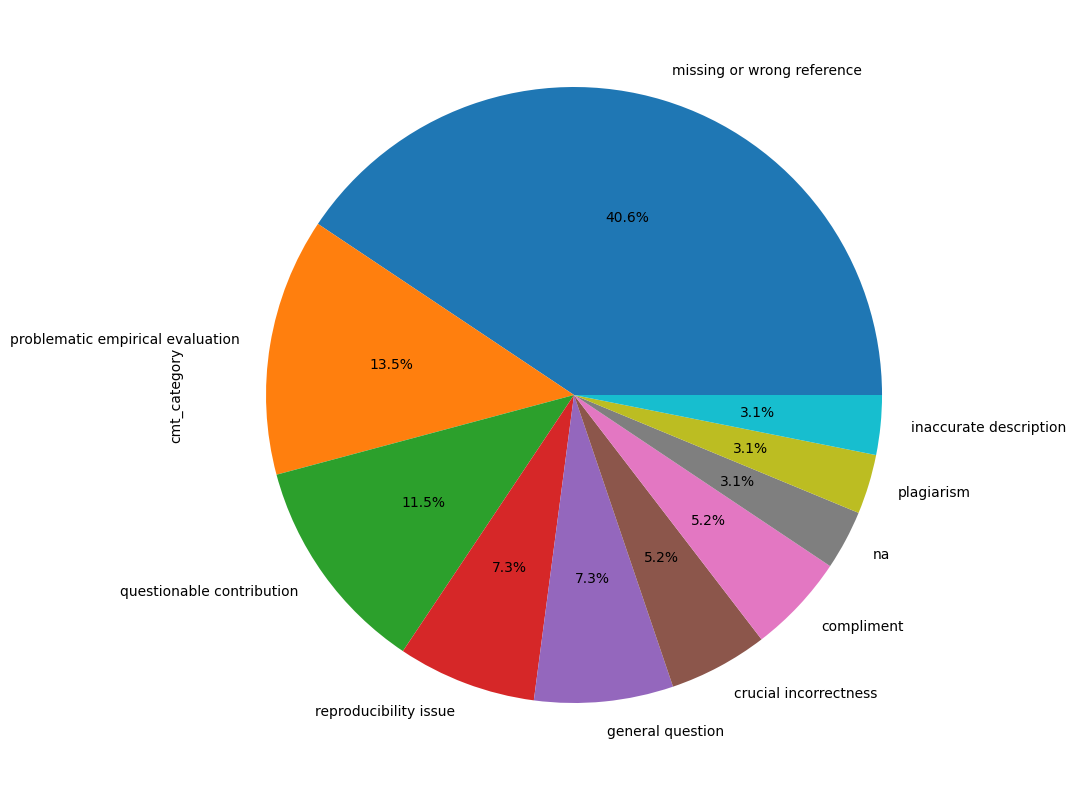

In [ ]:
df = df_pubCmts['cmt_category'].value_counts()
plot = df.plot.pie(figsize=(10,10), autopct='%1.1f%%')
plot

### 2.3 Does arxiv availability affect comment sentiment?

To investigate the potential impact of `arxiv_availability` on the sentiment of public comments, we analyzed the proportion of comments with each sentiment in relation to all comments. This analysis is visualized in the following pie charts, which depict the percentage of comments associated with each sentiment.

The three pie charts represent the distribution of sentiment scores for public comments based on the availability of arXiv preprints. Pie Chart 1 (leftmost) displays the sentiment scores for all comments, where 22.9% of the comments had a sentiment score of -1, while 21.9% had a score of -2. Half of the comments had a sentiment score of 0, indicating a neutral sentiment, while only 5.2% had a sentiment score of 2, indicating a positive sentiment.

Pie Chart 2 (middle) shows the sentiment scores for comments posted during the period when an arXiv preprint is accessible. Compared to Pie Chart 1, there is a slightly higher proportion of positive sentiments, with 7.7% of the comments having a sentiment score of 2. 23.1% of the comments had a sentiment score of -2, while 19.2% had a score of -1.

Pie Chart 3 (rightmost) displays the sentiment scores for comments posted when an arXiv preprint is not accessible. The distribution is similar to Pie Chart 1, with 21.4% of the comments having a sentiment score of -2, while 24.3% had a score of -1. Half of the comments had a sentiment score of 0, while only 4.3% had a score of 2, indicating a small proportion of positive sentiments. Overall, the sentiment scores for the comments appear to be generally neutral, with a slightly higher proportion of positive sentiments when an arXiv preprint is accessible.

We further perform two chi-square test to examine whether the sentiment distribution is different by arxiv preprint availability. For both tests, we state the hypotheses as follows:

  - $H_0$: the distribution of sentiment scores is the same for comments whether arxiv is available or not,
  - $H_a$: the distribution of sentiment scores is different for comments whether arxiv is available or not.

We set the significance level at $\alpha=0.1$.

For the initial test, we utilized the precise score to classify the sentiment of the comments, and this produced the following contingency table:

|   | -2 | -1 | 0 | 2 |
|---|:--:|:--:|:-:|:-:|
|arxiv\_available| 6 | 5 | 13 | 2 |
|arxiv\_unavailable| 15 | 17 | 35 | 3 |

The chi-square statistic for this contingency table is 1.1, and the associated p-value at $\chi^2_3$ is greater than 0.1, which indicates that the null hypothesis cannot be rejected.

For the second test, we employed a simplified description of the comment sentiments by merging the -2 and -1 sentiment levels into a single category called "negative sentiment", while renaming sentiment level 0 as "neutral sentiment" and sentiment level 2 as "positive sentiment".

|   | negative sentiment | neutral sentiment | positive sentiment |
|---|:--:|:--:|:-:|
|arxiv\_available| 11 | 13 | 2 |
|arxiv\_unavailable| 32 | 35 | 3 |

In this case, the chi-square statistic is 0.47, and the corresponding p-value at $\chi^2_2$ is less than 0.1, indicating that the null hypothesis cannot be rejected.

To summarize, although the pie charts indicate a small enhancement in comment sentiment when an arxiv preprint is available at the time of posting, the level of statistical significance is inadequate to deem it a significant improvement.


array([<Axes: ylabel='all'>, <Axes: ylabel='arxiv_available'>,
       <Axes: ylabel='arxiv_unavailable'>], dtype=object)

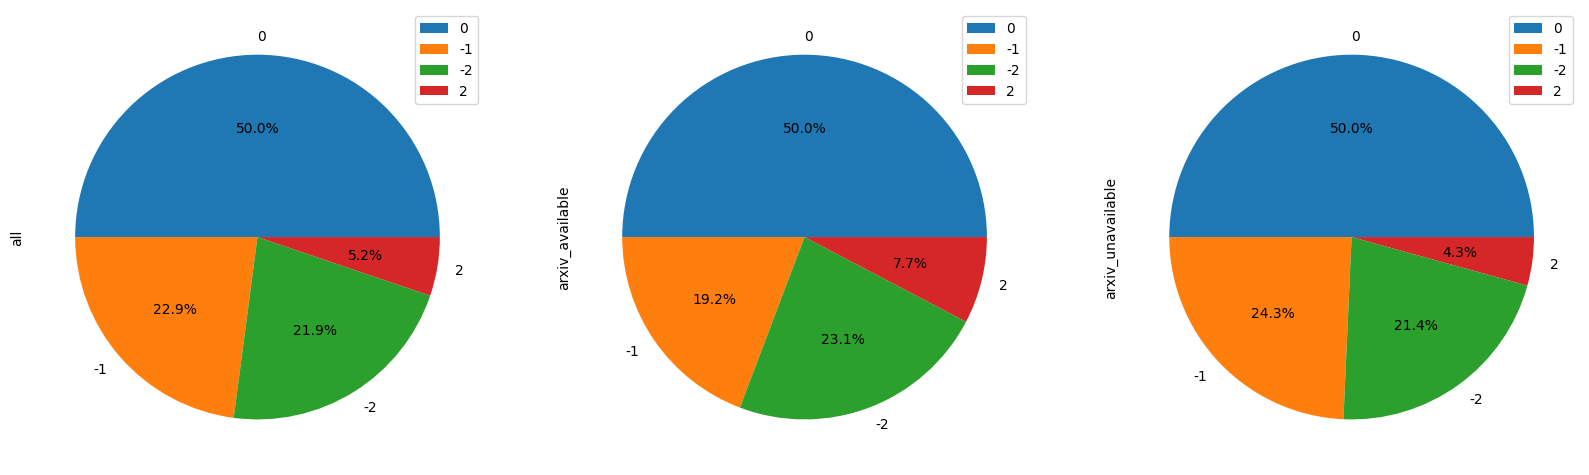

In [ ]:
countDict = df_pubCmts['cmt_sentiment'].value_counts().to_dict()      # {0: 48, -1: 22, -2: 21, 2: 5}
countDict = dict(map(lambda x: (x[0], [x[1]]), countDict.items()))    # {0: [48], -1: [22], -2: [21], 2: [5]}

arxiv_T = df_pubCmts.loc[df_pubCmts['arxiv_availability'] == True]['cmt_sentiment'].value_counts().to_dict()
for k, v in arxiv_T.items():
  countDict[k].append(v)
for k in (set(countDict.keys()) - set(arxiv_T.keys())):
  countDict[k].append(0)

for k, v in countDict.items():
  countDict[k].append(countDict[k][0] - countDict[k][1])

countDF = pd.DataFrame.from_dict(countDict, orient='index', columns=['all', 'arxiv_available', 'arxiv_unavailable'])
countDF.plot.pie(subplots=True, figsize=(20, 60), autopct='%1.1f%%')

In [ ]:
countDF

,all,arxiv_available,arxiv_unavailable
0,48,13,35
-1,22,5,17
-2,21,6,15
2,5,2,3


### 2.4 Does review rating affect comment sentiment?

This part of study aims to investigate whether the review rating affects comment sentiment. We utilize ordinal regression analysis, with the dependent variable being comment sentiment categorized into 5 levels ranging from -2 to 2. Three explanatory variables are employed, namely the average rating score given by reviewers (`avg_score`), the arxiv availability (`arxiv_availability`) and their interaction (`score_&_arxiv`). We set the significance level $\alpha=0.1$.

The coefficient associated with `arxiv_availability` is 0.1666, with a p-value of 0.518; the coefficient associated with `score_&_arxiv` is 0.3496, with a p-value 0.163. Both coefficients are positive but not statistically significant, indicating that arxiv accessibility did not have a substantial effect on comment sentiment, which is in agreement with the conclusion we draw from the previous study. On the other hand, the coefficient associated with `avg_score` is -0.2154, with a p-value of 0.064. The coefficient for average review rating is negative and approached statistical significance, suggesting that a higher review rating is associated with more negative comment sentiment.

The result indicates that commenters tend to be more critical towards papers that receive higher review ratings.



In [ ]:
# retrieve average review rating from dataframe 'df_iclr23'
df_iclr23_ = df_iclr23[['id_forum', 'avg_score']].copy()
df_sec2 = df_pubCmts.merge(df_iclr23_, how='left', left_on='paper_id', right_on='id_forum')
df_sec2 = df_sec2[['paper_id', 'cmt_id', 'cmt_sentiment', 'arxiv_availability', 'avg_score']]
df_sec2.head()

,paper_id,cmt_id,cmt_sentiment,arxiv_availability,avg_score
0,6iEoTr-jeB7,RSHAXYU0R1,-1,False,6.666667
1,0OlEBibFa_g,MwBZ9qaqVj,0,False,3.000000
2,cZM4iZmxzR7,f_UYiyBMbbQ,0,False,4.750000
3,cZM4iZmxzR7,1zQPZtBK4X,0,False,4.750000
4,688hNNMigVX,eDYga8Xhm7,-1,False,8.000000


In [ ]:
df_sec2.dtypes

paper_id               object
cmt_id                 object
cmt_sentiment           int64
arxiv_availability       bool
avg_score             float64
dtype: object

In [ ]:
from pandas.api.types import CategoricalDtype

cmt_senti_catType = CategoricalDtype(categories=[-2, -1, 0, 2], ordered=True)         # no instance from category '1' is observed, incorporating category '1' will cause a thresholding problem in ordered regression.
df_sec2['cmt_sentiment'] = df_sec2['cmt_sentiment'].astype(float)
df_sec2['arxiv_availability'] = df_sec2['arxiv_availability'].astype(float)
df_sec2['score_&_arxiv'] = df_sec2['avg_score'] * df_sec2['arxiv_availability']
df_sec2.dtypes

paper_id               object
cmt_id                 object
cmt_sentiment         float64
arxiv_availability    float64
avg_score             float64
score_&_arxiv         float64
dtype: object

In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_sec2[['avg_score']] = scaler.fit_transform(df_sec2[['avg_score']])

model = OrderedModel(df_sec2['cmt_sentiment'], df_sec2[['avg_score', 'arxiv_availability', 'score_&_arxiv']], distr='probit')
result = model.fit(method='bfgs', disp=False)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:          cmt_sentiment   Log-Likelihood:                -109.61
Model:                   OrderedModel   AIC:                             231.2
Method:            Maximum Likelihood   BIC:                             246.6
Date:                Mon, 08 May 2023                                         
Time:                        06:50:44                                         
No. Observations:                  96                                         
Df Residuals:                      90                                         
Df Model:                           6                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
avg_score             -0.2928      0.129     -2.266      0.023      -0.546      -0.040
arxiv_availability    -2.1062      1.648     -1.278      0.201      -5.337       1.125
score_&_arxiv          0.3496      0.250      1.396      0.163      -0.141       0.840
-2.0/-1.0             -0.7547      0.159     -4.740      0.000      -1.067      -0.443
-1.0/0.0              -0.4115      0.192     -2.148      0.032      -0.787      -0.036
0.0/2.0                0.6085      0.129      4.714      0.000       0.356       0.862
======================================================================================
"""

## 3. On The Presence of Public Comments

In this section, we investigate the impact of two key factors on the presence of open comments during the rebuttal period of ICLR 2023. Specifically, we explore the influence of the presence of an arxiv preprint before the start of the rebuttal period, *i.e.*, `pp_b4_rebuttal`, as well as the average rating score assigned by official reviewers, *i.e.*, `avg_score`. We create a binary indicator for the presence of an arxiv preprint (`pp_b4_rebuttal`) by comparing the arxiv_cdate with the official review release datetime. We also calculate the mean of review ratings submitted by official reviewers (`avg_score`) as a measure of the quality of the submission. By analyzing these factors, we aim to shed light on the drivers of open comments in the peer-review process.

In [ ]:
df_sec3= df_iclr23[['id_forum', 'avg_score', 'arxiv_cdate', 'pub_cmtids']].copy()

# add column: has comments
df_sec3['has_cmts'] = 0
df_sec3.loc[df_sec3['pub_cmtids'] != '[]', 'has_cmts'] = 1

# add column: perprint before rebuttal,
# here we compare arxiv_cdate with the official reivew release time Nov 05 '22 01:00 AM UTC
rebuttal_start = pd.Timestamp(year=2022, month=11, day=5, hour=1, tz='utc')
df_sec3['arxiv_cdate'] = pd.to_datetime(df_sec3['arxiv_cdate']).dt.tz_convert(tz='utc')
df_sec3['pp_b4_rebuttal'] = 0
df_sec3.loc[df_sec3['arxiv_cdate'] < rebuttal_start, 'pp_b4_rebuttal'] = 1

df_sec3.head()

,id_forum,avg_score,arxiv_cdate,pub_cmtids,has_cmts,pp_b4_rebuttal
0,RUzSobdYy0V,6.333333,NaT,[],0,0
1,N3kGYG3ZcTi,3.250000,NaT,[],0,0
2,tmIiMPl4IPa,6.600000,2021-11-27 03:34:13+00:00,[],0,1
3,mhnHqRqcjYU,6.666667,NaT,[],0,0
4,sZI1Oj9KBKy,6.250000,NaT,[],0,0


### 3.1 Does preprint attract open comments?


The research question in this experiment is whether publishing a preprint before the rebuttal period attracts open comments. The method used to analyze this question is the chi-square test, which examines the statistical dependency between the two categorical variables `has_cmts` ("has comments") and `pp_b4_rebuttal` ("has preprint before rebuttal"). A contingency table is formed to compare the frequencies of these two variables, and the chi-square statistic is calculated to test the null hypothesis of independence. The significance level is set at $\alpha=0.1$. The result shows that the chi-square statistic is 1.45, and the associated p-value at the chi-square distribution with one degree of freedom is greater than 0.1. This suggests that there is no significant association between publishing a preprint before rebuttal and attracting open comments. Therefore, the result indicates that the presence of a preprint before the rebuttal period does not seem to be a strong driver of open comments in the peer-review process.

In [ ]:
contingencyTab = pd.crosstab(index=df_sec3['has_cmts'], columns=df_sec3['pp_b4_rebuttal'])
contingencyTab

pp_b4_rebuttal,0,1
has_cmts,,
0,2578,1177
1,65,22


### 3.2 The relationship between review rating and the presence of comments

The research question in this experiment is to investigate the relationship between review rating and the presence of comments during the rebuttal period. The method used is probit regression, with `has_cmts` ("has comments") as the dependent variable and `avg_score` ("average rating score"), `pp_b4_rebuttal` ("has preprint before rebuttal"), and their interaction as independent variables. The significance level is set at $\alpha=0.1$.

The result shows that there is a significant positive relationship between review rating and the presence of comments, with a coefficient of 0.2009 and a p-value of 0.000. This suggests that submissions with higher review ratings are more likely to receive comments during the rebuttal period. However, the coefficient associated with "has preprint before rebuttal" is not significant, with a coefficient of -0.6147 and a p-value of 0.311. This indicates that the presence of a preprint before rebuttal does not significantly affect the likelihood of receiving comments. This finding is compatible with the results from the previous section, which also suggest that the presence of a preprint before the rebuttal period is not a strong driver of open comments during the peer-review process. Moreover, the interaction term between review rating and preprint before rebuttal is also not significant, with a coefficient of 0.0630 and a p-value of 0.664. This suggests that the effect of review rating on the presence of comments does not depend on the presence of a preprint before rebuttal. Overall, the results suggest that review rating is an important factor in attracting comments during the rebuttal period, while the presence of a preprint before rebuttal does not seem to have a significant impact.

In [ ]:
from statsmodels.discrete.discrete_model import Probit
from statsmodels.tools import add_constant

df_sec3['preprint_and_avgScore'] = df_sec3['pp_b4_rebuttal'] * df_sec3['avg_score']
endog = df_sec3['has_cmts']
exdog = add_constant(df_sec3[['avg_score', 'pp_b4_rebuttal', 'preprint_and_avgScore']])
model = Probit(endog, exdog)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.103595
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:               has_cmts   No. Observations:                 3842
Model:                         Probit   Df Residuals:                     3838
Method:                           MLE   Df Model:                            3
Date:                Mon, 08 May 2023   Pseudo R-squ.:                 0.04220
Time:                        06:50:50   Log-Likelihood:                -398.01
converged:                       True   LL-Null:                       -415.55
Covariance Type:            nonrobust   LLR p-value:                 1.175e-07
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.0997      0.265    -11.693      0.000      -3.619      -2.580
avg_score                 0.2009      0.044      4.528      0.000       0.114       0.288
pp_b4_rebuttal           -0.6147      0.606     -1.014      0.311      -1.803       0.574
preprint_and_avgScore     0.0630      0.095      0.664      0.507      -0.123       0.249
=========================================================================================
"""

## 4. The Impact of Open Comments

In this section, we investigate the impact of open comments on the acceptance of papers. Specifically, we estimate the individual average treatment effect of four factors on the acceptance of a submission. These four factors include: (1) `has_cmts`, a binary indicator that equals 1 if the paper receives at least one comment and 0 otherwise; (2) `has_negative_cmts`, a binary indicator that equals 1 if the average sentiment score of the comments received by a submission is negative and 0 if it receives no comments; (3) `has_neutral_cmts`, a binary indicator that equals 1 if the average sentiment score of the comments received by a submission is 0 and 0 if it receives no comments; and (4) `has_positive_cmts`, a binary indicator that equals 1 if the average sentiment score of the comments received by a submission is positive and 0 if it receives no comments. By estimating the treatment effects of these factors, we can better understand the impact of open comments on the acceptance of submissions.

In this study, the treatment group is significantly smaller than the control group, so a matching-based method will be used to estimate the treatment effect. For covariate selection, previous studies have shown that arxiv availability is not correlated with treatment assignment (i.e., receiving comments), so it will not be included as a covariate. The only covariate included will be average review rating, as it is known to be correlated. Due to having only one covariate, exact matching can be utilized.

In [ ]:
import numpy as np


df_sec4 = df_iclr23[['id_forum', 'decision', 'avg_score', 'arxiv_cdate', 'pub_cmtids']].copy()

# add column: acceptance
df_sec4['acceptance'] = 0
df_sec4.loc[df_sec4['decision'].str.contains('Accept'), 'acceptance'] = 1

# add column: has_cmts
df_sec4['has_cmts'] = 0
df_sec4.loc[df_sec4['pub_cmtids'] != '[]', 'has_cmts'] = 1

# add column: cmt_sentiment
df_sec4_pubcmts = df_pubCmts[['paper_id', 'cmt_sentiment']].copy()
df_sec4_pubcmts = df_sec4_pubcmts.groupby('paper_id', as_index=False)['cmt_sentiment'].mean()   # without specifying 'as_index=False', the code returns a pd.Series instead of a dataframe
df_sec4 = df_sec4.merge(df_sec4_pubcmts, how='left', left_on='id_forum', right_on='paper_id').drop(columns=['paper_id'])

# add column: has negative comments
df_sec4['has_negative_cmts'] = np.nan
df_sec4.loc[df_sec4['has_cmts'] == 0, 'has_negative_cmts'] = 0
df_sec4.loc[df_sec4['cmt_sentiment'] < 0, 'has_negative_cmts'] = 1

# add column: has neutral comments
df_sec4['has_neutral_cmts'] = np.nan
df_sec4.loc[df_sec4['has_cmts'] == 0, 'has_neutral_cmts'] = 0
df_sec4.loc[df_sec4['cmt_sentiment'] == 0, 'has_neutral_cmts'] = 1

# add column: has positive comments
df_sec4['has_positive_cmts'] = np.nan
df_sec4.loc[df_sec4['has_cmts'] == 0, 'has_positive_cmts'] = 0
df_sec4.loc[df_sec4['cmt_sentiment'] > 0, 'has_positive_cmts'] = 1

df_sec4.head()

,id_forum,decision,avg_score,arxiv_cdate,pub_cmtids,acceptance,has_cmts,cmt_sentiment,has_negative_cmts,has_neutral_cmts,has_positive_cmts
0,RUzSobdYy0V,Accept: poster,6.333333,NaN,[],1,0,NaN,0.0,0.0,0.0
1,N3kGYG3ZcTi,Reject,3.250000,NaN,[],0,0,NaN,0.0,0.0,0.0
2,tmIiMPl4IPa,Accept: poster,6.600000,2021-11-27 03:34:13+00:00,[],1,0,NaN,0.0,0.0,0.0
3,mhnHqRqcjYU,Accept: poster,6.666667,NaN,[],1,0,NaN,0.0,0.0,0.0
4,sZI1Oj9KBKy,Accept: poster,6.250000,NaN,[],1,0,NaN,0.0,0.0,0.0


In [ ]:
from tabulate import tabulate
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from scipy.stats import t

class MtchAvgScore():
  '''
  Estimating average treatment effect of factor <treatment key> using exact matching.

  The process of matching involves searching for the k-nearest neighbors in the control group for each instance (d_t) in the treatment group, based on the similarity of their covariates.
  In this study, the only covariate is 'avg_score'
  '''
  def __init__(self):
    self.covname = 'avg_score'

  def fit(self, data, k_neighbors=10, caliper_scalar=None, disp=False):

    # get treatment group: df_t and control group: df_c
    treatment_key = (set(data.columns) - set([self.covname, 'id_forum', 'acceptance'])).pop()
    grouped = data.groupby(treatment_key)
    df_t, df_c = grouped.get_group(1), grouped.get_group(0)

    # set the radius of k-neighbor searching
    if caliper_scalar is None:
      caliper_scalar = .25
    caliper = data[self.covname].std() * caliper_scalar

    # fit a knn model on the control group
    k = k_neighbors
    knn = NearestNeighbors(n_neighbors=k, radius=caliper).fit(df_c[[self.covname]])
    distances, neighbor_indices = knn.kneighbors(df_t[[self.covname]])

    # create the match table
    # we replicate the values of the factors associated with the treatment group k times in the treatment group's dataframe
    self.df_match = pd.DataFrame(columns=['id_t', 'avg_score_t', 'acceptance_t',  'id_c', 'avg_score_c', 'acceptance_c'])
    self.df_match['id_t'] = df_t['id_forum'].repeat(k)
    self.df_match['avg_score_t'] = df_t['avg_score'].repeat(k)
    self.df_match['acceptance_t'] = df_t['acceptance'].repeat(k)

    # accoridng to the matching result, we retrieve the values of the factors associated with the control group from the control group's dataframe
    id_c = []
    avg_score_c = []
    acceptance_c = []
    for nbrs in neighbor_indices:
      id_c += df_c.iloc[nbrs]['id_forum'].tolist()
      avg_score_c += df_c.iloc[nbrs]['avg_score'].tolist()
      acceptance_c += df_c.iloc[nbrs]['acceptance'].tolist()

    self.df_match['id_c'] = id_c
    self.df_match['avg_score_c'] = avg_score_c
    self.df_match['acceptance_c'] = acceptance_c

    self.df_TE = self.df_match.groupby('id_t')[['avg_score_t', 'acceptance_t', 'avg_score_c', 'acceptance_c']].aggregate('mean')
    self.df_TE['diff'] = self.df_TE['acceptance_t'] - self.df_TE['acceptance_c']

    if disp:
      print('match table')
      print(self.df_match.head(2*k))
      print('aggregated match table')
      print(self.df_TE)

    return self


  def summary(self, **kwargs):
    print('------------- Estimate ATE -------------')
    ate = self._estimate_ATE()
    print(f'The estimation of ATE is {ate:.4f}')

    print('\n'*3 + '------------- Significance of Estimated ATE -------------')
    bstrp_iter = 1000 if 'bstrp_iter' not in kwargs else kwargs['bstrp_iter']
    sample_mean, sample_mean_std, t_stat, p_value = self._examine_ATE_significance(bstrp_iter)

    tab = [['sample mean', 'sample mean std', 't-stat', 'p-value'], [sample_mean, sample_mean_std, t_stat, p_value]]
    print(tabulate(tab, headers='firstrow', tablefmt='fancy_grid'))

    print('\n'*3 + '------------- Matching balancedness examination -------------')
    boxplot = self._examine_mtch_balance()
    print(boxplot)


  def _estimate_ATE(self):
    return self.df_TE['diff'].mean()


  def _examine_mtch_balance(self):
    df_match = self.df_match.copy()
    df_match['rand_avg_score_c'] = df_sec41_c.sample(n=len(df_match), replace=True, random_state=1, ignore_index=True)['avg_score']
    boxplot = df_match.boxplot(column=['avg_score_t', 'avg_score_c', 'rand_avg_score_c'])
    return boxplot


  def _examine_ATE_significance(self, bstrp_iter=1000):

    n = len(self.df_TE)

    ates = []
    for i in tqdm(range(bstrp_iter)):
      self.df_TE_ = self.df_TE.sample(n=n, replace=True, random_state=i)
      ate_ = self.df_TE_['diff'].mean()
      ates.append(ate_)

    sample_mean = np.mean(ates)
    sample_mean_std = np.std(ates, ddof=1) / bstrp_iter ** .5

    t_stat = (sample_mean - 0) / sample_mean_std
    dof = bstrp_iter - 1
    p_value = 2*(t.cdf(-abs(t_stat), dof))

    return sample_mean, sample_mean_std, t_stat, p_value


### 4.1 The effect of the presence of comments on paper acceptance


For the matching process, we use the k-nearest-neighbor algorithm to match each treatment group instance to a subgroup of $k$ control group instances with the most similar average review scores ($k=10$). This is done to ensure that the matched control group instances are as similar as possible to the treatment group instances, minimizing any potential confounding effects.

To examine the balancedness of the matched data, we plot three box plots. The first box plot shows the distribution of average scores in the treatment group, the second box plot shows the distribution of average scores in the matched control group, and the third box plot shows the distribution of average scores in a random sample from the control group, which has the same size as the matched control group. We can see that the second box plot is almost identical to the first box plot, indicating that the matching process has been successful in creating a balanced control group. However, the third box plot exhibits a significantly lower median and a larger interquartile range than the first box plot, suggesting a greater degree of heterogeneity and less balance in the distribution of the covariate values in the random control group compared to the matched control group.

To estimate the average treatment effect, we calculate the difference between the outcome of each treatment group instance and the average outcome of the matched subgroup of control group instances. We then take the average of all the differences to obtain the average treatment effect (ATE), which is estimated to be 0.0874. The ATE of 0.0874 indicates that the presence of open comments has a positive effect on the acceptance of the paper. This means that papers with open comments are more likely to be accepted than those without open comments.

To assess the significance of the ATE estimate, we use bootstrap to create a random sample of ATE estimates. The sample mean is 0.0863 and the sample mean standard deviation is 0.0010. We use a one-sample t-test to test the null hypothesis that the true ATE is equal to zero. The p-value is less than 0.05, indicating that the ATE estimate is statistically significant.

------------- Estimate ATE -------------
The estimation of ATE is 0.0874



------------- Significance of Estimated ATE -------------


100%|██████████| 1000/1000 [00:00<00:00, 1690.69it/s]


╒═══════════════╤═══════════════════╤══════════╤═══════════╕
│   sample mean │   sample mean std │   t-stat │   p-value │
╞═══════════════╪═══════════════════╪══════════╪═══════════╡
│     0.0863471 │        0.00103471 │  83.4506 │         0 │
╘═══════════════╧═══════════════════╧══════════╧═══════════╛



------------- Matching balancedness examination -------------
Axes(0.125,0.11;0.775x0.77)


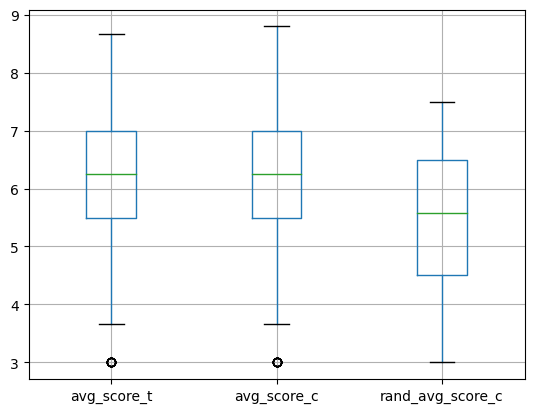

In [ ]:
df_sec41 = df_sec4[['id_forum', 'acceptance', 'avg_score', 'has_cmts']].copy()

matchModel = MtchAvgScore()
matchResult = matchModel.fit(df_sec41)
matchResult.summary()

### 4.2 Impact of negative, neutral, and positive comments

In this section, we investigate the impact of negative, neutral, and positive comments on paper acceptance. We estimate the average treatment effect of the presence of these comments on the acceptance of submissions. For this analysis, we use the same exact matching-based method used in section 4.1, but the treatment factors used here are `has_negative_cmts`, `has_neutral_cmts`, and `has_positive_cmts`. The method of assignment can be found by referring to the opening paragraph of section 4.

We use the same exact matching process as in section 4.1 to match each treatment group instance to a subgroup of k=10 control group instances with the most similar average review scores. The balancedness of the matched data is examined by comparing the distribution of average scores in the treatment group, matched control group, and a random sample from the control group.

The estimation of the average treatment effect (ATE) is calculated by taking the difference between the outcome of each treatment group instance and the average outcome of the matched subgroup of control group instances. The ATE for the presence of negative comments is estimated to be 0.1225, the ATE of neutral comments on the acceptance of papers is estimated to be 0.0488, the estimation of the average treatment effect (ATE) of positive comments that it is 0.1500. Indicating that the presence of comments regardless of sentiment has a positive effect on the acceptance of the paper. This means that papers with comments of any sentiment are more likely to be accepted than those without any comments. This is in agreement with the observations of the previous section.

To assess the significance of the ATE estimate, we use bootstrap to create a random sample of ATE estimates. For the each sentiment type we use a one-sample t-test to test the null hypothesis that the true ATE is equal to zero. The p-value for each test resulted in a score below 0.1, indicating that the ATE estimate is statistically significant for all three tests.


Below are the test results for negative commments

------------- Estimate ATE -------------
The estimation of ATE is 0.1225



------------- Significance of Estimated ATE -------------


100%|██████████| 1000/1000 [00:00<00:00, 1670.54it/s]


╒═══════════════╤═══════════════════╤══════════╤═══════════╕
│   sample mean │   sample mean std │   t-stat │   p-value │
╞═══════════════╪═══════════════════╪══════════╪═══════════╡
│      0.121813 │        0.00116399 │  104.651 │         0 │
╘═══════════════╧═══════════════════╧══════════╧═══════════╛



------------- Matching balancedness examination -------------
Axes(0.125,0.11;0.775x0.77)


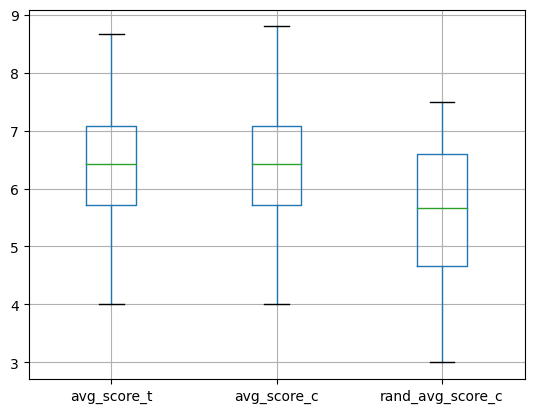

In [ ]:
df_sec42 = df_sec4[['id_forum', 'acceptance', 'avg_score', 'has_negative_cmts']].copy()
df_sec42 = df_sec42.loc[df_sec42['has_negative_cmts'].notna()]

matchModel = MtchAvgScore()
matchResult = matchModel.fit(df_sec42)
matchResult.summary()

Below are the test results for neutral commments

------------- Estimate ATE -------------
The estimation of ATE is 0.0488



------------- Significance of Estimated ATE -------------


100%|██████████| 1000/1000 [00:00<00:00, 1633.73it/s]


╒═══════════════╤═══════════════════╤══════════╤══════════════╕
│   sample mean │   sample mean std │   t-stat │      p-value │
╞═══════════════╪═══════════════════╪══════════╪══════════════╡
│     0.0472233 │        0.00174667 │  27.0362 │ 2.97221e-121 │
╘═══════════════╧═══════════════════╧══════════╧══════════════╛



------------- Matching balancedness examination -------------
Axes(0.125,0.11;0.775x0.77)


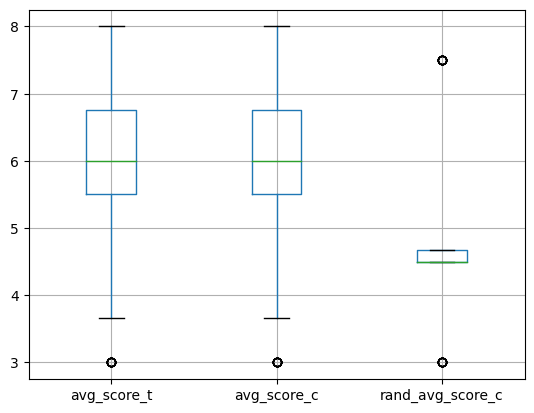

In [ ]:
df_sec43 = df_sec4[['id_forum', 'acceptance', 'avg_score', 'has_neutral_cmts']].copy()
df_sec43 = df_sec43.loc[df_sec43['has_neutral_cmts'].notna()]

matchModel = MtchAvgScore()
matchResult = matchModel.fit(df_sec43)
matchResult.summary()

Below are the test results for positive commments

------------- Estimate ATE -------------
The estimation of ATE is 0.1500



------------- Significance of Estimated ATE -------------


100%|██████████| 1000/1000 [00:00<00:00, 1854.15it/s]


╒═══════════════╤═══════════════════╤══════════╤══════════════╕
│   sample mean │   sample mean std │   t-stat │      p-value │
╞═══════════════╪═══════════════════╪══════════╪══════════════╡
│        0.1521 │        0.00422829 │   35.972 │ 1.94457e-182 │
╘═══════════════╧═══════════════════╧══════════╧══════════════╛



------------- Matching balancedness examination -------------
Axes(0.125,0.11;0.775x0.77)


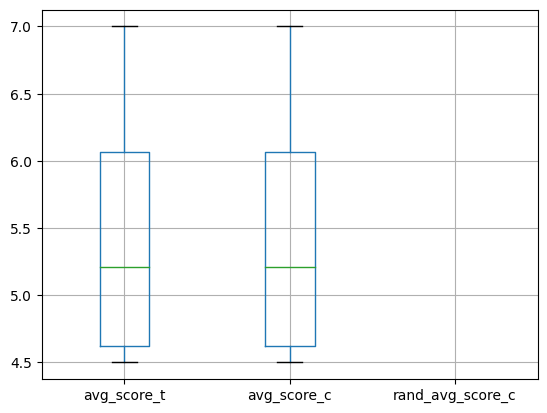

In [ ]:
df_sec44 = df_sec4[['id_forum', 'acceptance', 'avg_score', 'has_positive_cmts']].copy()
df_sec44 = df_sec44.loc[df_sec44['has_positive_cmts'].notna()]

matchModel = MtchAvgScore()
matchResult = matchModel.fit(df_sec44)
matchResult.summary()

## 5. Conclusion

In this study, we have presented a comprehensive analysis of the impact of public comments on the peer-review process in academic publishing. We have investigated various aspects of public comments, including their categories, sentiments, and impact on paper acceptance, as well as the potential effects of arXiv availability and review rating on comment sentiments and the presence of comments.

Our findings suggest that the presence of comments, in general, has a positive impact on the acceptance of a paper. We found this result to be the case regardless of comment sentiment, so for all types of comments, their presence positively influences the acceptance rate of the paper.

Interestingly, the presence of a preprint before the rebuttal period did not significantly affect the likelihood of receiving comments. This was surprising given that we expect stronger papers to have published preprints as a sign of confidence, and we found that submissions with higher review ratings are more likely to receive comments during the rebuttal period.

One limitation of this study is that we focused only on public comments that start a new thread by their own, and left other types of comments (e.g., voluntary response to official reviews) to future studies. Additionally, our analysis is based solely on the comments and papers in the ICLR2023 dataset, which may not be representative of all academic publishing venues. Furthermore, we only look at a single covariate in section 4, which could limit the accuracy of our results. Future research could explore the generalizability of our findings to other fields and publishing venues.

Overall, our study provides valuable insights into the role of public comments in the peer-review process and highlights the importance of considering various factors, such as review rating and comment sentiment, in evaluating the impact of comments on paper acceptance.